In [1]:
from src.models import train_model, infer_model, create_distance_matrix
from src.utils import read_chat_from_json
from src.featurizer import featurize_msg_pairs
from src.dataset_builder import generate_msg_pairs
import src.constants as c
import numpy as np

In [2]:
sns_new = read_chat_from_json('/home/ivan/Desktop/result.json').tail(1000)

In [3]:
sns_new.text_entities.apply(lambda x: ''.join(list(x[0]['type']))).value_counts()

plain      979
link        12
mention      5
hashtag      2
italic       1
bold         1
Name: text_entities, dtype: int64

In [4]:
path_sns_moscow = './data/sns_moscow/result.json'
sns_moscow = read_chat_from_json(path_sns_moscow).tail(1000)

In [5]:
pairs_train = generate_msg_pairs(sns_moscow, 2, 100)
features_train = featurize_msg_pairs(pairs_train, sns_moscow)

In [6]:
pairs_infer = generate_msg_pairs(sns_moscow, 100, 100)
features_infer = featurize_msg_pairs(pairs_infer, sns_moscow)

In [8]:
print(pairs_infer.shape, pairs_infer.shape)
print(features_train.shape, features_infer.shape)

(94858, 28) (94858, 28)
(2563, 19) (94858, 19)


In [ ]:
# процент ответов этому человеку?
# общались ли они уже => фича не равна нулю

In [9]:
pairs_train.query('y == 1').shape

(569, 28)

In [10]:
import pandas as pd
pairs_train['autor_pair'] = pairs_train.apply(lambda row: ''.join(sorted([row['from_id_orig'], row['from_id_repl']])), axis=1)
pairs_train.loc[pairs_train.y == 1, 'n_cross_msg'] = pairs_train.query('y == 1').groupby('autor_pair')['y'].transform(pd.Series.cumsum) - 1

In [168]:
pairs_train['n_from'] = (pairs_train.groupby('from_id_orig')['y'].transform(pd.Series.cumsum) - 1)
pairs_train['n_to'] = (pairs_train.groupby('from_id_repl')['y'].transform(pd.Series.cumsum) - 1).replace([np.inf, -np.inf], 0) 

In [171]:
pairs_train = (
    pairs_train
    .eval('freq_from = n_cross_msg / n_from')
    .eval('freq_to = n_cross_msg / n_to')
    .fillna({
        'freq_from': 0,
        'freq_to': 0
    })
)
pairs_train['freq_from'] = pairs_train['freq_from'].replace([np.inf, -np.inf], 0) 
pairs_train['freq_to'] = pairs_train['freq_to'].replace([np.inf, -np.inf], 0) 

In [ ]:
#sine-cosine encoding времени суток, или факторный

In [175]:
pairs_train[['from_orig', 'from_repl', 'text_orig', 'text_repl', 'n_from', 'freq_from', 'n_to', 'freq_to']].head(30)

from_orig          from_repl  \
0              Iván 🍵      Кирилл Чуркин   
1       Кирилл Чуркин             Iván 🍵   
2       Dmitrii Dyago             Danya🔥   
3       Dmitrii Dyago  Nikolay Tkachenko   
4       Dmitrii Dyago      Oleg Ur [MSK]   
5              Danya🔥           Larisa M   
6              Danya🔥  Александр Краснов   
7              Danya🔥      Alexey Kuzmin   
8              Danya🔥              Алекс   
9            Larisa M             Danya🔥   
10           Larisa M      Alexey Kuzmin   
11           Larisa M  Алиса Альционская   
12             Iván 🍵      Кирилл Чуркин   
13      Кирилл Чуркин           Larisa M   
14             Danya🔥  Nikolay Tkachenko   
15             Danya🔥           Larisa M   
16  Nikolay Tkachenko             Danya🔥   
17           Larisa M           Larisa M   
18  Nikolay Tkachenko  Александр Краснов   
19  Nikolay Tkachenko             Danya🔥   
20  Nikolay Tkachenko           Alexandr   
21  Nikolay Tkachenko           Larisa M   
22  Александр Краснов  Nikolay Tkachenko   
23           Larisa M  Nikolay Tkachenko   
24  Nikolay Tkachenko  Александр Краснов   
25  Александр Краснов  Nikolay Tkachenko   
26  Nikolay Tkachenko           Larisa M   
27             Danya🔥             Danya🔥   
28           Larisa M  Nikolay Tkachenko   
29             Danya🔥  Nikolay Tkachenko   

                                            text_orig  \
0       Это там где за такси начисляют и снимают 10%?   
1                        Разверни мысль, я не в курсе   
2   в том то и дело, что сервиса три с половиной, ...   
3   в том то и дело, что сервиса три с половиной, ...   
4   в том то и дело, что сервиса три с половиной, ...   
5   Рекомендации Яндекс.Музыки нравятся больше Спо...   
6   Рекомендации Яндекс.Музыки нравятся больше Спо...   
7   Рекомендации Яндекс.Музыки нравятся больше Спо...   
8   Рекомендации Яндекс.Музыки нравятся больше Спо...   
9   Мое личное ощущение что рекомендации Яндекс Му...   
10  Мое личное ощущение что рекомендации Яндекс Му...   
11  Мое личное ощущение что рекомендации Яндекс Му...   
12  https://vc.ru/services/192721-razbor-fakecheck...   
13  Меня смущает, что некоторые говорят что Яндекс...   
14  На КиноПоиске больше фильмов/сериалов, которые...   
15  Начал тоже схожее замечать\nНо я связал это с ...   
16  На всякий случай, у кинопоиска одна из самых м...   
17  Ну вообще продукты у них нормальные. Можете по...   
18  1. Яндекс.еда — постоянно не работает всё что ...   
19  1. Яндекс.еда — постоянно не работает всё что ...   
20  1. Яндекс.еда — постоянно не работает всё что ...   
21  Я даже не хочу особо продолжать — из нормальны...   
22                Да скажи что-нибудь лучше, хейтер!)   
23                           Маркет и Алиса тоже норм   
24  Да, я откровенно скажу — я хейтер Яндекса. Мне...   
25                                Да лучше то что))))   
26  Маркет — это тот, который привёз мне айрподсы ...   
27               4. Все это делают :)\nГуголь тоже :)   
28  Ты какой-то прям везучий ничего не могу сказат...   
29  Так что это не проблема Яндекса, а в целом поч...   

                                            text_repl  n_from  freq_from  \
0                        Разверни мысль, я не в курсе       0   0.000000   
1   https://vc.ru/services/192721-razbor-fakecheck...       0   0.000000   
2   Тем что они лучше?)\nКарты для России лучше гу...       0   0.000000   
3                                              Угу, +       1   0.000000   
4   Те, кто пользуется картами, драйвом и поиском,...       2   0.000000   
5   Мое личное ощущение что рекомендации Яндекс Му...       0   0.000000   
6                  Нет караоке мода - все идут лесом)       1   0.000000   
7   У меня спотифай просто рекомендации не показыв...       2   0.000000   
8                               Вот тут я не согласен       3   0.000000   
9   Начал тоже схожее замечать\nНо я связал это с ...       0   0.000000   
10  Мне в последнее время кажется, что они 

In [128]:
pairs_train = pairs_train.drop(['cumsum'], axis=1)

In [111]:
pairs_train.tail(20)

id_orig           date_orig          edited_orig  \
1974    35162 2021-05-27 21:52:44                  NaN   
1975    35160 2021-05-27 21:52:08                  NaN   
1976    35167 2021-05-27 22:35:35                  NaN   
1977    35209 2021-05-28 19:20:59                  NaN   
1978    35216 2021-05-29 12:15:19                  NaN   
1979    35234 2021-05-30 13:33:49  2021-05-30T16:45:43   
1980    35162 2021-05-27 21:52:44                  NaN   
1981    35163 2021-05-27 22:27:39  2021-05-27T22:28:01   
1982    35184 2021-05-28 00:29:38                  NaN   
1983    35192 2021-05-28 08:47:15                  NaN   
1984    35199 2021-05-28 11:56:02                  NaN   
1985    35175 2021-05-28 00:18:43                  NaN   
1986    35200 2021-05-28 11:59:47                  NaN   
1987    35201 2021-05-28 12:22:30                  NaN   
1988    35203 2021-05-28 13:39:28  2021-05-28T13:43:55   
1989    35227 2021-05-30 01:54:16                  NaN   
1990    35228 2021-05-30 01:55:27                  NaN   
1991    35200 2021-05-28 11:59:47                  NaN   
1992    35214 2021-05-28 21:53:52                  NaN   
1993    35225 2021-05-30 01:49:24                  NaN   

                        from_orig   from_id_orig  \
1974                 Francis Reed   user59832444   
1975                Станислав МГУ  user358274362   
1976                Станислав МГУ  user358274362   
1977           Alexander Bokhenek  user168885266   
1978                Станислав МГУ  user358274362   
1979                        Diana   user35286658   
1980                 Francis Reed   user59832444   
1981                       Evgeny  user191058689   
1982        Anastasia Gaydashenko  user175307798   
1983          Valentina Dolganova   user98585757   
1984                   Артур Лисс   user66366854   
1985                       Evgeny  user191058689   
1986          Valentina Dolganova   user98585757   
1987                        Арман  user204651015   
1988                       Evgeny  user191058689   
1989  Анатолий Жуковский (Quasar)  user281389974   
1990                Станислав МГУ  user358274362   
1991          Valentina Dolganova   user98585757   
1992                         Seva   user47693290   
1993                 Francis Reed   user59832444   

                                              text_orig forwarded_from_orig  \
1974                                            Спасибо                 NaN   
1975                                         либо так))                 NaN   
1976  можно даже поспать пару часиков, пока мероприя...                 NaN   
1977  у них на сайте написано, что он закрылся. а он...                 NaN   
1978  напоминаю, что сегодня ночью квартирник)\nhttp...                 NaN   
1979  Привет всем, \n\nЛечу в Москву из Лондона на ~...                 NaN   
1980                                            Спасибо                 NaN   
1981  А что там происходит, если в сущности? Пост пр...                 NaN   
1982  Мне нравится Андерсон: там довольно простая и ...                 NaN   
1983  А я порекомендую «Старик и море» на чистых пру...                 NaN   
1984  Интересно, не было даже мысли, что не на второ...                 NaN   
1985  Посоветуйте прикольное место и прикольную еду....                 NaN   
1986  Я  его первый раз прочитала у Игоря сообщением...                 NaN   
1987  слово, очевидно, с французскими корнями, так ч...                 NaN   
1988  На практике язык происхождения ничего не говор...                 NaN   
1989                                         А что это?                 NaN   
1990                               Ночной квартирник  )                 NaN   
1991  Я  его первый раз прочитала у Игоря сообщением...                 NaN   
1992                            В личке скинул описание                 NaN   
1993                         А какая площадь помещения?                 NaN   

                                  

In [95]:
[tuple(i.values()) for i in pairs_train.query('y==1')[['id_orig', 'from_id_orig', 'from_id_repl']].to_dict(orient='records')]

[(34019, 'user256581511', 'user169372988'),
 (34020, 'user169372988', 'user256581511'),
 (34021, 'user108263676', 'user227422387'),
 (34021, 'user108263676', 'user257814622'),
 (34021, 'user108263676', 'user97478540'),
 (34023, 'user227422387', 'user110806063'),
 (34023, 'user227422387', 'user138164087'),
 (34023, 'user227422387', 'user344678286'),
 (34023, 'user227422387', 'user429859230'),
 (34025, 'user110806063', 'user227422387'),
 (34025, 'user110806063', 'user344678286'),
 (34025, 'user110806063', 'user288563563'),
 (34028, 'user256581511', 'user169372988'),
 (34029, 'user169372988', 'user110806063'),
 (34030, 'user227422387', 'user257814622'),
 (34031, 'user227422387', 'user110806063'),
 (34032, 'user257814622', 'user227422387'),
 (34033, 'user110806063', 'user110806063'),
 (34037, 'user257814622', 'user138164087'),
 (34037, 'user257814622', 'user227422387'),
 (34037, 'user257814622', 'user180180011'),
 (34039, 'user257814622', 'user110806063'),
 (34040, 'user138164087', 'user25

In [ ]:
features_train.columns

In [9]:
features_train.groupby(c.TARGET).agg({'has_mention_orig': np.mean})

has_mention_orig
y                  
0          0.025075
1          0.024605

In [ ]:
features_train.query('f_bow_jaccard > 0')[TARGET].mean()

In [ ]:
features_train.query('f_bow_jaccard > 0')['f_bow_jaccard']

In [11]:
features_train.groupby(c.TARGET).agg({'has_link_orig': [np.mean]})

has_link_orig
           mean
y              
0      0.061184
1      0.059754

In [12]:
features_train.isna().mean()

time_diff            0.0
id_diff              0.0
time_per_msg         0.0
len_orig             0.0
len_repl             0.0
has_link_orig        0.0
has_link_repl        0.0
has_mention_orig     0.0
has_mention_repl     0.0
has_question_orig    0.0
has_question_repl    0.0
same_author          0.0
edited_orig          0.0
edited_repl          0.0
wc_orig              0.0
wc_repl              0.0
bow_jaccard          0.0
emb_cosine_sim       0.0
y                    0.0
dtype: float64

In [47]:
sns_moscow.columns

Index(['id', 'date', 'edited', 'from', 'from_id', 'text',
       'reply_to_message_id', 'forwarded_from', 'photo', 'via_bot', 'file',
       'thumbnail', 'media_type'],
      dtype='object')

In [ ]:
# pair of authors who previously communicated

<AxesSubplot:>

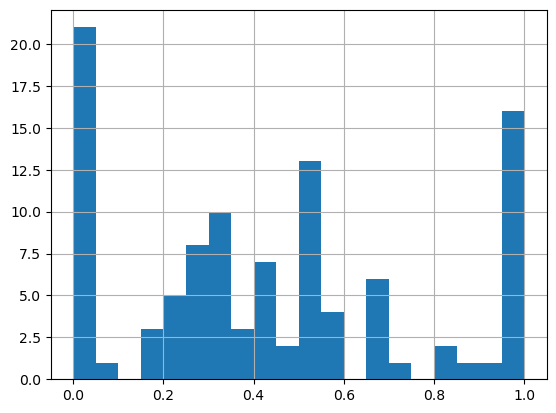

In [11]:
sns_moscow.isna().groupby(sns_moscow.from_id)['reply_to_message_id'].mean().hist(bins=20)

In [ ]:
# autor paticipation in the last X messages
# top-x authors?
# author ambedding
# author gender

In [43]:
features_train.dtypes

ValueError: DataFrame.dtypes for data must be int, float, bool or category.  When
                categorical type is supplied, DMatrix parameter `enable_categorical` must
                be set to `True`.id_diff, time_per_msg, same_author

time_diff            float64
id_diff                Int64
time_per_msg         Float64
len_orig               int64
len_repl               int64
has_link_orig          int64
has_link_repl          int64
has_mention_orig       int64
has_mention_repl       int64
has_question_orig      int64
has_question_repl      int64
same_author            Int64
edited_orig            int64
edited_repl            int64
wc_orig                int64
wc_repl                int64
bow_jaccard          float64
emb_cosine_sim       float32
y                      int64
dtype: object

In [42]:
import xgboost as xgb

 # = xgb.XGBClassifier()
params = {
    'monotone_constraints': {
        'id_diff': -1,
        'time_diff': -1,
        'emb_cosine_sim': 1,
    }
}
model = xgb.XGBClassifier(**params)
dtrain = xgb.DMatrix(
    features_train.drop(columns=c.TARGET).values,
    feature_names=features_train.drop(columns=c.TARGET).columns
)
dinfer = xgb.DMatrix(
    features_infer.drop(columns=c.TARGET).values,
    features_infer[c.TARGET].values,
    feature_names=features_infer.drop(columns=c.TARGET).columns
)

# xgtest = xgb.DMatrix(features_infer.drop(columns=c.TARGET))
model = model.fit(features_train.drop(columns=c.TARGET), features_train[c.TARGET].values)

/home/ivan/miniconda3/envs/chat_segmentation/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


ValueError: DataFrame.dtypes for data must be int, float, bool or category.  When
                categorical type is supplied, DMatrix parameter `enable_categorical` must
                be set to `True`.id_diff, time_per_msg, same_author

In [35]:
model.predict_proba(dinfer)

AttributeError: 'Booster' object has no attribute 'predict_proba'

In [12]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# model = DecisionTreeClassifier(max_depth=5)
# model = LogisticRegression()
model = GradientBoostingClassifier(n_estimators=30)
# model = RandomForestClassifier(class_weight='balanced', random_state=14)
train_model(features_train, model)
output_tr = infer_model(features_train, model)
output_infer = infer_model(features_infer, model)

In [13]:
import pandas as pd
pd.DataFrame({
    'name': features_train.drop(columns=c.TARGET).columns,
     'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

name  importance
1             id_diff    0.805703
0           time_diff    0.073278
16        bow_jaccard    0.034783
17     emb_cosine_sim    0.023584
11        same_author    0.020272
3            len_orig    0.012004
9   has_question_orig    0.010079
14            wc_orig    0.007986
4            len_repl    0.007805
2        time_per_msg    0.001632
6       has_link_repl    0.001504
15            wc_repl    0.001369
5       has_link_orig    0.000000
7    has_mention_orig    0.000000
8    has_mention_repl    0.000000
10  has_question_repl    0.000000
12        edited_orig    0.000000
13        edited_repl    0.000000

In [14]:
output_tr.y_hat.value_counts(normalize=True)

0    0.805306
1    0.194694
Name: y_hat, dtype: float64

In [15]:
output_infer.y_hat.value_counts(normalize=True)

0    0.959603
1    0.040397
Name: y_hat, dtype: float64

In [16]:
def create_response_matrix(model_scores: pd.DataFrame) -> np.array:
    ids = model_scores['id_orig'].drop_duplicates()
    n = len(ids)
    id2idx = dict(zip(ids, range(n)))
    matrix = np.zeros((n, n), dtype=float)
    for row in model_scores.to_dict(orient='records'):
        if id2idx.get(row['id_repl']):
            matrix[id2idx[row['id_repl']], id2idx[row['id_orig']]] = row['prob'] if row['y'] == 0 else row['y']
    return matrix

In [18]:
from sklearn.metrics import f1_score, roc_auc_score

f1_score(features_train[c.TARGET], model.predict(features_train.drop(columns=c.TARGET)))

0.8389513108614232

y
0    AxesSubplot(0.125,0.11;0.775x0.77)
1    AxesSubplot(0.125,0.11;0.775x0.77)
Name: emb_cosine_sim, dtype: object

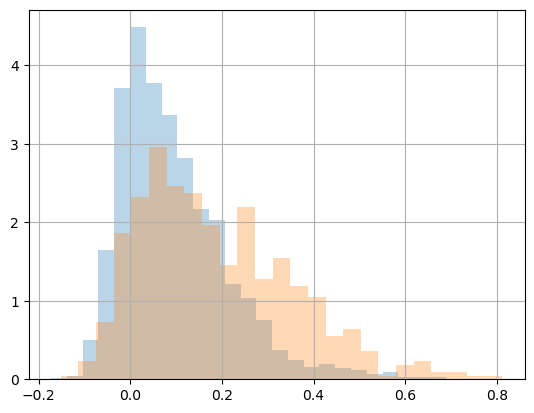

In [20]:
features_train.groupby('y')['emb_cosine_sim'].hist(density=True, alpha=0.3, bins=25)

y
0    AxesSubplot(0.125,0.11;0.775x0.77)
1    AxesSubplot(0.125,0.11;0.775x0.77)
Name: emb_cosine_sim, dtype: object

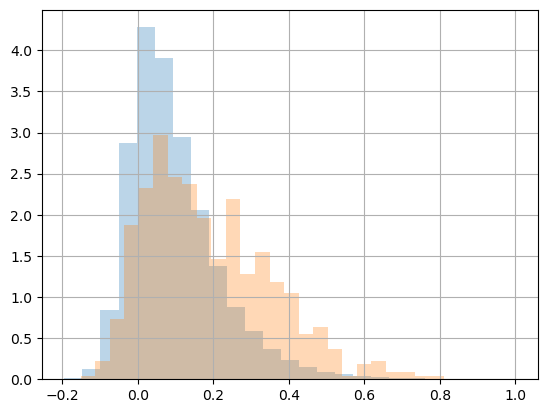

In [22]:
features_infer.groupby('y')['emb_cosine_sim'].hist(density=True, alpha=0.3, bins=25)

In [29]:
from sklearn.metrics import confusion_matrix
confusion_matrix(features_train[c.TARGET], model.predict(features_train.drop(columns=c.TARGET)), normalize=None)

array([[1943,   51],
       [ 121,  448]])

In [31]:
pd.Series(model.predict_proba(features_train.drop(columns=c.TARGET))[:, 1]).describe()

count    2563.000000
mean        0.222725
std         0.312529
min         0.025621
25%         0.026241
50%         0.043019
75%         0.258549
max         0.931846
dtype: float64

In [ ]:
output_tr.prob.describe()

In [ ]:
output_infer.prob.describe()

In [ ]:
import matplotlib.pyplot as plt
dist_inf, idx2id_infer = create_distance_matrix(output_infer)
plt.figure(figsize=(8, 8))
plt.imshow(dist_inf);

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(data)
dendrogram(dist_inf)

In [ ]:
diss = 1 - (dist_inf + dist_inf.T)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(diss);

In [ ]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(linkage='average', distance_threshold=0.95, n_clusters=None, affinity='precomputed')
clustering.fit(diss)

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

In [ ]:
data_sbs = sns_moscow.tail(1000).copy()
data_sbs['cluster'] = clustering.labels_

In [ ]:
data_sbs['cluster'].value_counts().sort_values().head(40)

In [ ]:
data_sbs.query('cluster == 20')[['date', 'from', 'text', 'reply_to_message_id']].head(40)

In [ ]:
data_sbs.query('cluster == 1')[['date', 'from', 'text', 'reply_to_message_id']].head(40)

In [ ]:
data_sbs.query('cluster == 2')[['date', 'from', 'text', 'reply_to_message_id']].head(50)

In [ ]:
data_sbs.query('cluster == 3')[['date', 'from', 'text', 'reply_to_message_id']].head(40)

In [ ]:
data_sbs.query('cluster == 4')[['date', 'from', 'text', 'reply_to_message_id']].head(40)

In [ ]:
data_sbs.query('cluster == 5')[['date', 'from', 'text', 'reply_to_message_id']].head(40)

In [ ]:
data_sbs.query('cluster == 6')[['date', 'from', 'text', 'reply_to_message_id']].head(40)

In [ ]:
data_sbs.query('cluster == 7')[['date', 'from', 'text', 'reply_to_message_id']].head(40)

In [ ]:
data_sbs.query('cluster == 8')[['date', 'from', 'text', 'reply_to_message_id']].head(40)

In [ ]:
data_sbs.query('cluster == 9')[['date', 'from', 'text', 'reply_to_message_id']].head(40)

In [ ]:
data_sbs.query('cluster == 10')[['date', 'from', 'text', 'reply_to_message_id']].head(40)

In [ ]:
data_sbs.query('cluster == 11')[['date', 'from', 'text', 'reply_to_message_id']].head(40)

In [ ]:
data_sbs.query('cluster == 12')[['date', 'from', 'text', 'reply_to_message_id']].head(40)

In [ ]:
data_sbs.query('cluster == 13')[['date', 'from', 'text', 'reply_to_message_id']].head(40)

In [ ]:
data_sbs.query('cluster == 14')[['date', 'from', 'text', 'reply_to_message_id']].head(40)

In [ ]:
data_sbs.query('cluster == 15')[['date', 'from', 'text', 'reply_to_message_id']].head(40)

In [ ]:
data_test['cluster'].value_counts()

In [ ]:
data_test.query('cluster == 4').loc[:, ['from', 'text']].head(50)